In [1123]:
from datetime import datetime, date
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from yellowbrick.regressor import PredictionError, ResidualsPlot
from mapie.regression import MapieRegressor
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from xgboost import plot_importance
from sklearn.utils import resample
from numpy import absolute
from scipy.stats import zscore
import pandas as pd
import shap
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

In [1124]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Predicting a Baby's Birth Weight

### Why?
Complications can result if your baby is not a normal weight.
- <b> Underweight (low birth weight): </b> less than 5 lbs, 8 ounces.  It is usually caused by being born too early (premature). Complications for being underweight include short term / long term complications like low oxygen levels at birth, breathing problems, nervous system problems, digestive problems, developmental delays. 
- <b> Overweight: </b> over 8 lbs, 13 ounces at birth. For the mother, it increases the need of a c-section, Type 2 diabetes, heart disease, asthma and obesity. If you have gestational diabetes, your baby could have problems with breathing, low glucose levels and jaundice.

In [1125]:
test.head(2)

,id,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,...,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN
0,108082,1,1,23.6,0,11,,8,1231,4,...,0,0,0,125,3,1,N,0,M,53
1,108083,1,1,20.1,0,7,1,4,851,5,...,0,2,2,103,4,2,Y,2,F,24


In [1126]:
train.head(2)

,id,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,...,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN,DBWT
0,0,1,1,18.5,0,12,,10,1434,5,...,0,0,108,1,1,N,0,F,24,2800
1,1,1,1,18.3,2,4,1,12,2156,6,...,2,1,100,1,1,N,0,M,18,1900


In [1127]:
# Transform weight from grams to pounds

def convert_to_lbs(grams):
    """
    Convert grams to pounds
    """
    pounds = grams * 0.00220462
    return pounds

In [1128]:
train['DBWT'] = train['DBWT'].apply(convert_to_lbs)

In [1129]:
# replace space results with nan

train = train.replace(r'^\s*$', np.nan, regex=True)
test = test.replace(r'^\s*$', np.nan, regex=True)

In [1130]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108082 entries, 0 to 108081
Data columns (total 38 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           108082 non-null  int64  
 1   ATTEND       108082 non-null  int64  
 2   BFACIL       108082 non-null  int64  
 3   BMI          108082 non-null  float64
 4   CIG_0        108082 non-null  int64  
 5   DLMP_MM      108082 non-null  int64  
 6   DMAR         94820 non-null   object 
 7   DOB_MM       108082 non-null  int64  
 8   DOB_TT       108082 non-null  int64  
 9   DOB_WK       108082 non-null  int64  
 10  FAGECOMB     108082 non-null  int64  
 11  FEDUC        108082 non-null  int64  
 12  ILLB_R       108082 non-null  int64  
 13  ILOP_R       108082 non-null  int64  
 14  ILP_R        108082 non-null  int64  
 15  LD_INDL      108082 non-null  object 
 16  MAGER        108082 non-null  int64  
 17  MBSTATE_REC  108082 non-null  int64  
 18  MEDUC        108082 non-

------
## Exploratory Data Analysis

### 1. Factors before pregnancy (not pregnancy related)

**MBSTATE_REC - Mother’s Nativity**:
- 1 Born in the U.S. (50 US States) 
- 2 Born outside the U.S. (includes possessions) 
- 3 Unknown or Not Stated

In [1131]:
# percentages
(train['MBSTATE_REC'].value_counts(dropna=False) / len(train))*100

MBSTATE_REC
1    77.069262
2    22.735516
3     0.195222
Name: count, dtype: float64

**DMAR - Marital Status** - United States: 1 Married, 2 Unmarried

In [1132]:
(train['DMAR'].value_counts(dropna=False) / len(train))*100

DMAR
1      52.650765
2      35.078922
NaN    12.270313
Name: count, dtype: float64

52% of mothers are married, 35% are unmarried, 12% no response.

**FEDUC - Father’s Education & MEDUC - Mother’s Education**:
- 1 8th grade or less 
- 2 9th through 12th grade with no diploma 
- 3 High school graduate or GED completed 
- 4 Some college credit, but not a degree. 
- 5 Associate degree (AA,AS)
- 6 Bachelor’s degree (BA, AB, BS) 
- 7 Master’s degree (MA, MS, MEng, MEd, MSW, MBA) 
- 8 Doctorate (PhD, EdD) or Professional Degree (MD, DDS, DVM, LLB, JD) 
- 9 Unknown   

In [1133]:
df_education_1 = pd.DataFrame()
df_education_2 = pd.DataFrame()
df_education_1['Value'] = train['FEDUC']
df_education_1['Name'] = "Father's Education"
df_education_2['Value'] = train['MEDUC']
df_education_2['Name'] = "Mother's Education"
df_education = pd.concat([df_education_1,df_education_2],axis=0)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


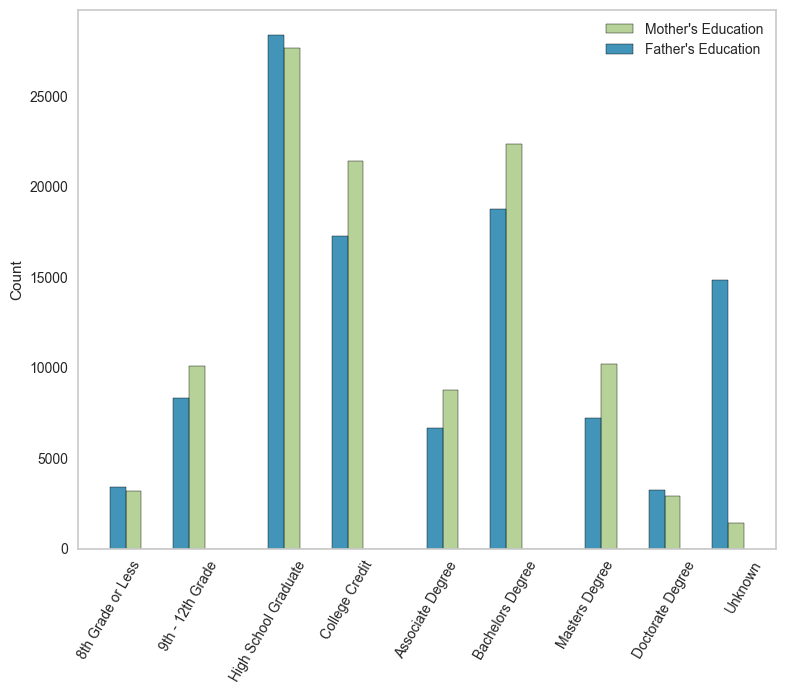

In [1134]:
ax = sns.histplot(data=df_education,x='Value',hue='Name',multiple='dodge',binwidth=0.4);
ax.grid(False);
ax.set(xlabel="");
ax.set_xticklabels(['None','8th Grade or Less','9th - 12th Grade','High School Graduate','College Credit',
                    'Associate Degree', 'Bachelors Degree','Masters Degree','Doctorate Degree','Unknown'], rotation=60);
plt.legend(title='',labels=["Mother's Education","Father's Education"])
plt.show();


- 25.6% of mothers are high school educated, 20% college educated (bachelor's degree), 19% with some college credit.
- 26% of fathers are high school educated, 17% college educated (bachelor's degree), 15% with some college credit.
- 13% of father's education data points are missing, whereas 1% are missing for mother's education.

**ILLB_R - Interval Since Last Live Birth Recode:** --> Time since last delivery? (Plural delivery -- 000-003, Months since last live birth 004-300, 888 (Not applicable / 1st natality event), 999 (Unknown or not stated)

**ILOP_R - Interval Since Last Other Pregnancy Recode:** - (Plural delivery -- 000-003, Months since last live birth 004-300, 888 (Not applicable / 1st natality event), 999 (Unknown or not stated)

**ILP_R - Interval Since Last Pregnancy Recode:** - (Plural delivery -- 000-003, Months since last live birth 004-300, 888 (Not applicable / 1st natality event), 999 (Unknown or not stated)

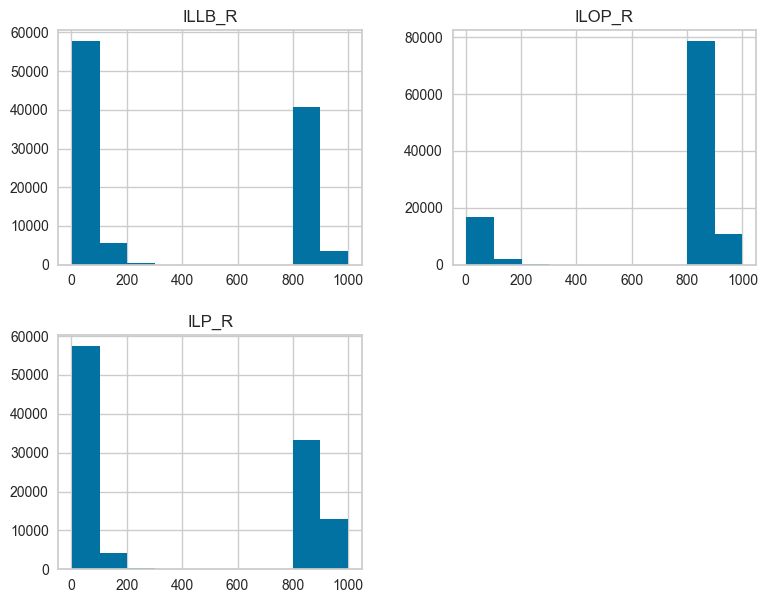

In [1135]:
train[['ILLB_R','ILOP_R','ILP_R']].hist();
plt.show();

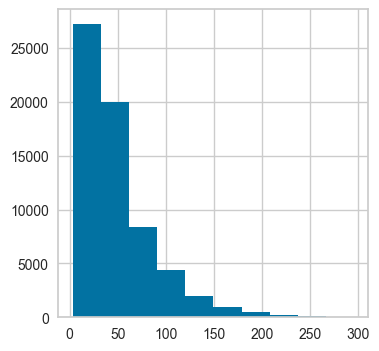

In [1136]:
train[train['ILLB_R'] < 300]['ILLB_R'].hist(figsize=(4,4))
plt.show();

- **BMI: Body Mass Index** - 13.0 - 69.9 BMI, 99.9 Unknown or not stated
- **CIG_0 - Cigarettes Before Pregnancy:** - 00-97, Number of cigarettes daily, 98, 98 or more cigarettes daily, 99 - Unknown or not stated
- **MAGER - Mother’s Single Years of Age:** - 10-12 years to 50: 50 years and older
- **M_Ht_In - Mother’s Height in Total Inches:** (30-78 Height in inches, 99 Unknown or not stated)
- **PWgt_R - Pre-pregnancy Weight Recode**: 075-375 Weight in pounds, 999 Unknown or not stated
- **FAGECOMB - Father’s Combined Age:** 09-98 Father’s combined age in years, 99 Unknown or not stated

In [1137]:
plot_categorical_df = pd.DataFrame()
plot_categorical_df['BMI_categorical'] = pd.cut(train['BMI'], bins=[10,20,25,30,40,50,60,70])
plot_categorical_df['CIG_0_categorical'] = train['CIG_0'].apply(lambda x: 0 if x == 0 else 1)
plot_categorical_df['MAGER_categorical'] = pd.cut(train['MAGER'], bins=[10,20,25,30,40,50,60,70])
plot_categorical_df['FAGECOMB_categorical'] = pd.cut(train['FAGECOMB'], bins=[10,20,25,30,40,50,60,70])
plot_categorical_df['M_Ht_In_categorical'] = pd.cut(train['M_Ht_In'], bins=[40,50,55,60,65,70,75,90])
plot_categorical_df['PWgt_R_categorical'] = pd.cut(train['PWgt_R'], bins=[50,100,150,200,250,300,350,400])

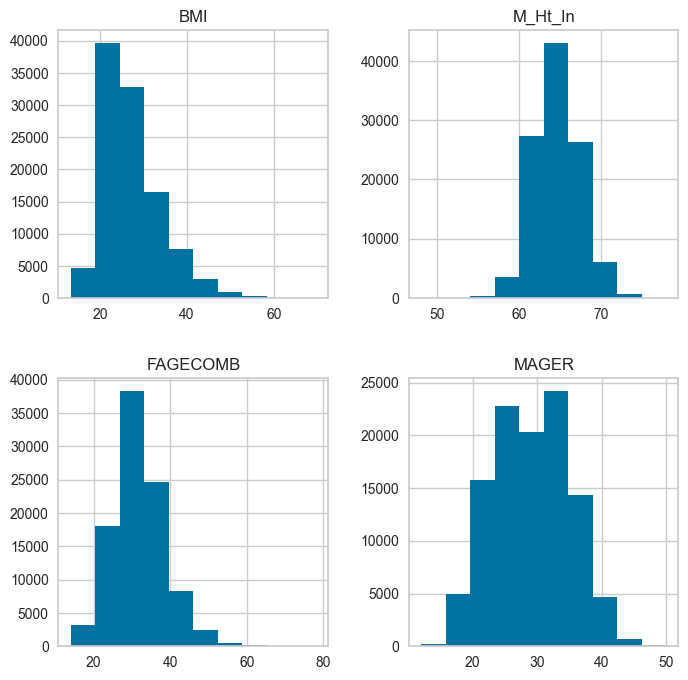

In [1138]:
train[train[['BMI','M_Ht_In','FAGECOMB','MAGER']] < 99][['BMI','M_Ht_In','FAGECOMB','MAGER']].hist(figsize=(8,8));
plt.show();

Around 60% of women have a BMI in the 20-30 range.

59.6% of mothers were between 5' to 5'5".

In [1139]:
(plot_categorical_df['PWgt_R_categorical'].value_counts(dropna=False) / len(train))*100

PWgt_R_categorical
(100.0, 150.0]    48.694510
(150.0, 200.0]    32.808423
(200.0, 250.0]    10.566052
(250.0, 300.0]     2.903351
(50.0, 100.0]      2.312133
NaN                2.023464
(300.0, 350.0]     0.581040
(350.0, 400.0]     0.111027
Name: count, dtype: float64

48.7% of mothers weighed between 100lbs to 150lbs before getting pregnant.

In [1140]:
(plot_categorical_df['M_Ht_In_categorical'].value_counts(dropna=False) / len(train))*100

M_Ht_In_categorical
(60.0, 65.0]    59.568661
(65.0, 70.0]    29.210229
(55.0, 60.0]     8.985770
(70.0, 75.0]     1.462778
NaN              0.507022
(50.0, 55.0]     0.177643
(75.0, 90.0]     0.047186
(40.0, 50.0]     0.040710
Name: count, dtype: float64

In [1141]:
(plot_categorical_df['FAGECOMB_categorical'].value_counts(dropna=False) / len(train))*100

FAGECOMB_categorical
(30.0, 40.0]    40.940212
(25.0, 30.0]    23.126885
(20.0, 25.0]    12.823597
NaN             11.642087
(40.0, 50.0]     7.574804
(10.0, 20.0]     2.946837
(50.0, 60.0]     0.852131
(60.0, 70.0]     0.093448
Name: count, dtype: float64

The father's age is between 30-40 for 41% of respondents. There is no age for 11.6% of fathers in the dataset.

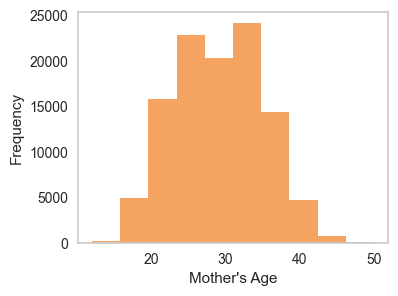

In [1142]:
ma = train[train[['MAGER']] < 99][['MAGER']].plot(
    kind='hist',
    figsize=(4,3),
    color='sandybrown',
    grid=False,
    legend=False
)
ma.set_xlabel("Mother's Age");

Most mothers are in their late 20's to early 30's. 69% of respondents were in the 25-40 age range.

In [1143]:
train[train[['MAGER']] < 99][['MAGER']].mean()

MAGER    29.004136
dtype: float64

The average mother's age is 29 years old.

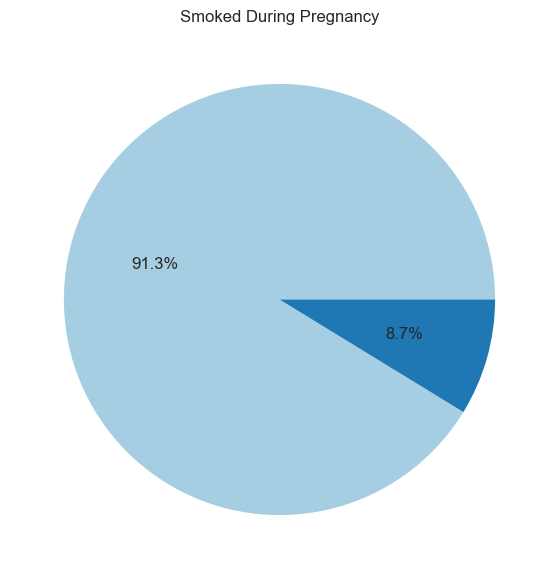

In [1144]:
cig_0_categorical = train['CIG_0'].apply(lambda x: 0 if x == 0 else 1)
cig_0 = (cig_0_categorical.value_counts(dropna=False) / len(train))*100

palette_color = sns.color_palette('Paired') 
plt.pie(cig_0, autopct='%1.1f%%',colors=palette_color);
plt.title("Smoked During Pregnancy");
plt.show();

91% of women did not smoke during pregnancy, ~9% did.

-------
### 2. Factors before pregnancy (pregnancy related)

**RF_CESAR - Previous Cesarean** - Y Yes N No U Unknown or not stated

In [1145]:
(train['RF_CESAR'].value_counts(dropna=False) / len(train))*100

RF_CESAR
N    84.233267
Y    15.766733
Name: count, dtype: float64

84% of mothers did not have a previous c-section.

**PRIORDEAD - Prior Births Now Dead:** - 00-30 Number of children dead from previous live births, 99 Unknown or not stated

In [1146]:
(train['PRIORDEAD'].value_counts(dropna=False) / len(train))*100

PRIORDEAD
0     98.620492
1      0.988139
99     0.223904
2      0.103625
3      0.031458
4      0.012028
9      0.005551
5      0.005551
10     0.002776
8      0.001850
6      0.001850
7      0.001850
12     0.000925
Name: count, dtype: float64

 1.2% of mothers have had a child that died during delivery.

**PRIORLIVE - Prior Births Now Living:** -00-30 Number of children still living from previous live births, 99 Unknown or not stated

In [1147]:
(train['PRIORLIVE'].value_counts(dropna=False) / len(train))*100

PRIORLIVE
0     37.985048
1     32.275495
2     17.131437
3      7.369405
4      2.882071
5      1.140801
6      0.495920
7      0.259988
99     0.158213
8      0.141559
9      0.088821
10     0.035158
11     0.020355
12     0.012028
13     0.001850
16     0.000925
14     0.000925
Name: count, dtype: float64

86% of respondents have either 0, 1 or 2 kids before this pregnancy.

**PRIORTERM - Prior Other Terminations:** - 00-30 Number other terminations, 99 Unknown or not stated

**RF_CESARN** - Number of Previous Cesareans (01-30 Number of previous cesareans, 00 None, 99 Unknown or not stated)

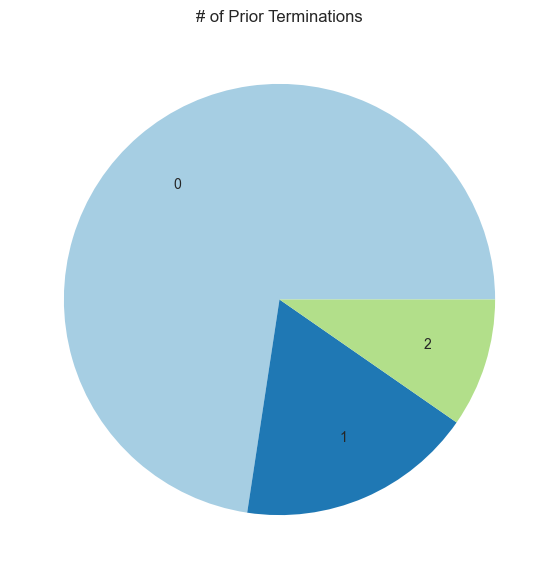

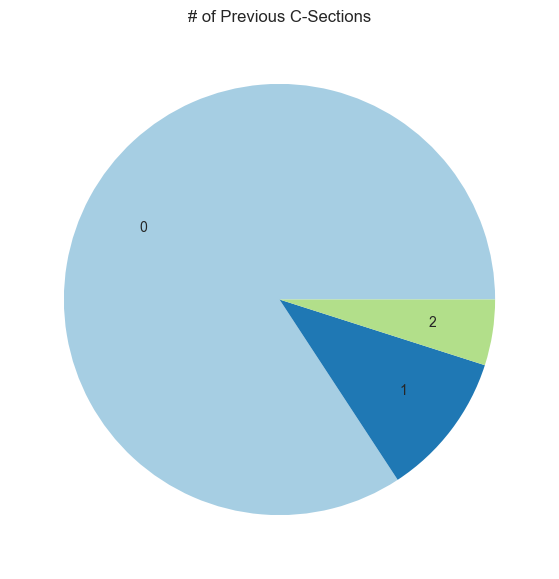

In [1148]:
pie_chart_variables = {
    'PRIORTERM': '# of Prior Terminations',
    'RF_CESARN': '# of Previous C-Sections'
}

for var, name in pie_chart_variables.items():

    pie_var = train[var].apply(lambda x: 2 if x > 2 else x)
    palette_color = sns.color_palette('Paired') 
    plt.title(name)

    patches, texts = plt.pie(
        x=pie_var.value_counts().values, 
        labels=pie_var.value_counts().index,
        colors=palette_color,
        # Bring labels inside the pie
        labeldistance=0.7
    )

    plt.show();

27% of mothers have had a prior termination.

---------
### 3. Factors During Pregnancy

**PRECARE: Month Prenatal Care Began**: 00 No prenatal care 01-10 Month prenatal care began 99 Unknown or not stated

**DLMP_MM - Last Normal Menses Month** - Last Period Month - 01 January 02 February 03 March 04 April 05 May 06 June 07 July 08 August 09 September 10 October 11 November 12 December 99 Unknown or not stated

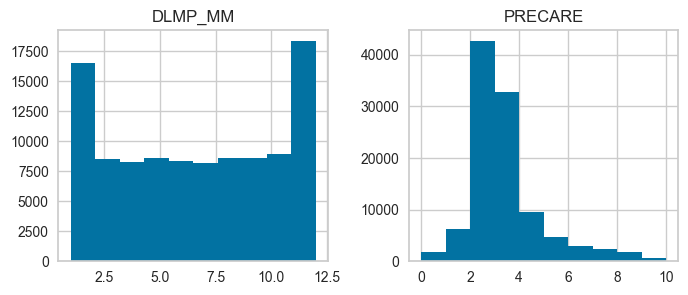

In [1149]:
train[train[['DLMP_MM','PRECARE']] < 99][['DLMP_MM','PRECARE']].hist(figsize=(8,3));
plt.show();

Most mothers (69%) started prenatal care within the second or third month of pregnancy. 

There isn't much variation with the last period month. 

**WTGAIN** - Weight Gain (00-97 weight gain in pounds, 98 pounds and over, 99 unknown or not stated)

**PREVIS** - Number of Prenatal Visits (00-98 Number of prenatal visits, 99 Unknown or not stated)

In [1150]:
plot_categorical_df['WTGAIN_categorical'] = pd.cut(train[train['WTGAIN'] < 99]['WTGAIN'], bins=[0,10,20,30,40,50,60,70,80,90,98])
plot_categorical_df['PREVIS_categorical'] = pd.cut(train[train['PREVIS'] < 99]['PREVIS'], bins=[0,5,10,15,20,40,60])
plot_boolean_df = pd.DataFrame()
plot_boolean_df['WTGAIN_boolean'] = train['WTGAIN'].apply(lambda x: 0 if x == 99 else 1)
plot_boolean_df['PREVIS_boolean'] = train['PREVIS'].apply(lambda x: 0 if x == 99 else 1)

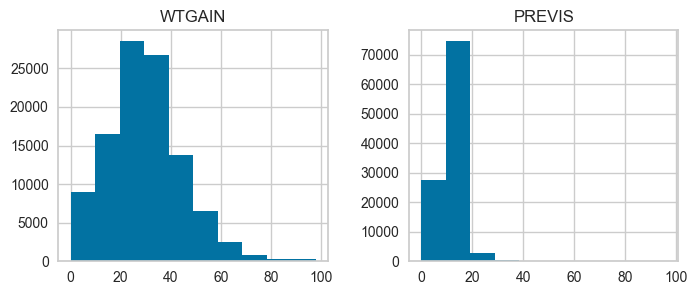

In [1151]:
train[train[['WTGAIN','PREVIS']] < 99][['WTGAIN','PREVIS']].hist(figsize=(8,3));
plt.show();

**NO_RISKS - No Risk Factors Reported** -  1 True, 0 False, 9 Not Reported (gestational diabetes, etc.)

In [1152]:
(train['NO_RISKS'].value_counts(dropna=False) / len(train))*100

NO_RISKS
1    68.555356
0    31.444644
Name: count, dtype: float64

**NO_INFEC - No Infections Reported** - 1 True, 0 False, 9 Not Reported (ex: Hep B)

In [1153]:
(train['NO_INFEC'].value_counts(dropna=False) / len(train))*100

NO_INFEC
1    97.057789
0     2.755315
9     0.186895
Name: count, dtype: float64

97% of mother's haven't had an infection before.

In [1154]:
(plot_categorical_df['WTGAIN_categorical'].value_counts(dropna=False) / len(train))*100

WTGAIN_categorical
(20.0, 30.0]    27.307970
(30.0, 40.0]    23.001055
(10.0, 20.0]    17.381248
(40.0, 50.0]    11.955737
(0.0, 10.0]      6.854980
NaN              5.839085
(50.0, 60.0]     4.796358
(60.0, 70.0]     1.750523
(70.0, 80.0]     0.661535
(80.0, 90.0]     0.235007
(90.0, 98.0]     0.216502
Name: count, dtype: float64

50% of mothers gained between 20-40 lbs.

In [1155]:
(plot_categorical_df['PREVIS_categorical'].value_counts(dropna=False) / len(train))*100

PREVIS_categorical
(10.0, 15.0]    49.273700
(5.0, 10.0]     31.212413
(15.0, 20.0]     7.791307
(0.0, 5.0]       5.709554
NaN              4.214393
(20.0, 40.0]     1.759775
(40.0, 60.0]     0.038859
Name: count, dtype: float64

In [1156]:
(plot_boolean_df['PREVIS_boolean'].value_counts(dropna=False) / len(train))*100

PREVIS_boolean
1    97.460262
0     2.539738
Name: count, dtype: float64

97.5% of mothers visited a doctor at least once before delivering. 

49% of mothers made between 10-15 visits to a doctor.

--------
### 4. Factors on the Delivery Day

**DOB_TT - Time of Birth:** (HHMM)

In [1157]:
dob_tt_hour = train[train['DOB_TT'] != 9999]['DOB_TT']

In [1158]:
dob_tt_hour = dob_tt_hour.astype('str')
dob_tt_hour = dob_tt_hour.str.zfill(4)
dob_tt_hour = dob_tt_hour.apply(lambda x: datetime.strftime(datetime.strptime(str(x), '%H%M'),format='%H'))

In [1159]:
((dob_tt_hour.value_counts() / len(dob_tt_hour))*100).head(5)

DOB_TT
08    6.386010
12    5.900259
13    5.387676
14    5.106403
10    5.072169
Name: count, dtype: float64

6% of babies are born at 8am.

**RESTATUS - Residence Status** 
- 1 RESIDENT: State and county of occurrence and residence are the same. 
- 2 INTRASTATE NONRESIDENT:  State of occurrence and residence are the same but county is different.
- 3 INTERSTATE NONRESIDENT: State of occurrence and residence are different but both are one of the 50 US states or District of Columbia. 
- 4 FOREIGN RESIDENT: The state of residence is not one of the 50 US states or District of Columbia. U.S. Territories 
                                 
**RDMETH_REC - Delivery Method Recode** 
- 1 Vaginal (excludes vaginal after previous C-section) 
- 2 Vaginal after previous c-section 
- 3 Primary C-section
- 4 Repeat C-section 
- 5 Vaginal (unknown if previous c-section) 
- 6 C-section (unknown if previous c-section) 
- 9 Not stated

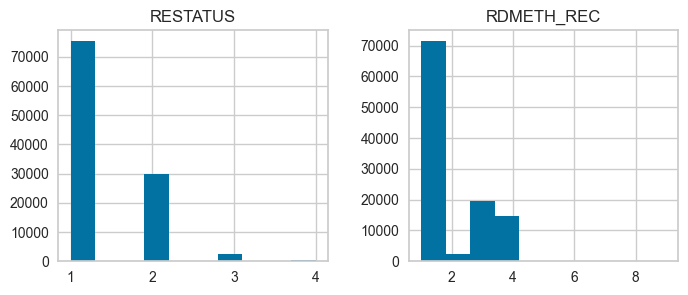

In [1160]:
train[['RESTATUS','RDMETH_REC']].hist(figsize=(8,3));
plt.show();

69.7% delivered in the same county. 27.6% were in a different county. 2.35% delivered in a different state.

68% of women delivered vaginally and 31% had a c-section.

**ATTEND - Attendant at Birth**: 1 Doctor of Medicine (MD) 2 Doctor of Osteopathy (DO) 3 Certified Nurse Midwife (CNM) 4 Other Midwife 5 Other 9 Unknown or not stated

In [1161]:
(train['ATTEND'].value_counts(dropna=False) / len(train))*100

ATTEND
1    80.871005
3     9.381766
2     8.043893
5     0.828075
4     0.823449
9     0.051813
Name: count, dtype: float64

89% of women delivered from a MD/DO.

**BFACIL - Birth Place**: 1 Hospital 2 Freestanding Birth Center 3 Home (intended) 4 Home (not intended) 5 Home (unknown if intended) 6 Clinic / Doctor’s Office 7 Other 9 Unknown

In [1162]:
(train['BFACIL'].value_counts(dropna=False) / len(train))*100

BFACIL
1    98.390111
3     0.741104
2     0.543106
4     0.123055
5     0.113802
7     0.064766
6     0.013878
9     0.010177
Name: count, dtype: float64

98% delivered in a hospital.

**PAY_REC - Payment Recode** - 1 Medicaid 2 Private Insurance 3 Self Pay 4 Other 9 Unknown

In [1163]:
(train['PAY_REC'].value_counts(dropna=False) / len(train))*100

PAY_REC
2    49.099758
1    42.117096
3     4.330971
4     3.876686
9     0.575489
Name: count, dtype: float64

49% of women paid with private insurance, followed by 42% paying with Medicaid

**DOB_MM - Birth Month** - 01 January 02 February 03 March 04 April 05 May 06 June 07 July 08 August 09 September 10 October 11 November 12 December

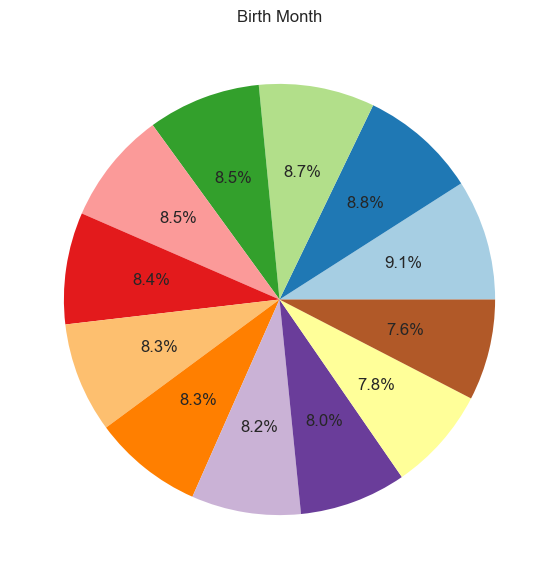

In [1164]:
dob_mm = (train['DOB_MM'].value_counts(dropna=False) / len(train))*100    
palette_color = sns.color_palette('Paired') 
plt.pie(dob_mm, autopct='%1.1f%%',colors=palette_color);
plt.title("Birth Month");
plt.show();

There isn't much of a difference with the month a baby is born.

**DOB_WK - Birth Day of Week**: 1 Sunday 2 Monday 3 Tuesday 4 Wednesday 5 Thursday 6 Friday 7 Saturday

In [1165]:
(train['DOB_WK'].value_counts(dropna=False) / len(train))*100

DOB_WK
6    16.085010
4    16.002665
3    15.948076
5    15.887012
2    15.283766
7    11.059196
1     9.734276
Name: count, dtype: float64

Out of all the days, the least amount of babies are born on Sundays.

**SEX - Sex of Infant**  - M Male, F Female

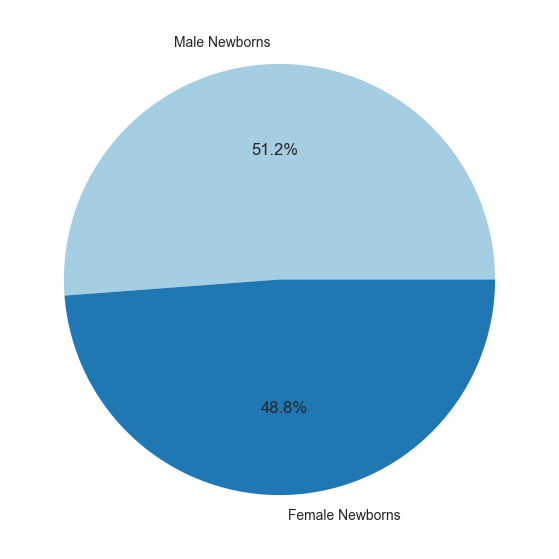

In [1166]:
palette_color = sns.color_palette('Paired') 
pie = (train['SEX'].value_counts(dropna=False) / len(train))*100
plt.pie(pie, labels=['Male Newborns','Female Newborns'], autopct='%1.1f%%',colors=palette_color);
plt.show();

In [1167]:
(train['RESTATUS'].value_counts(dropna=False) / len(train))*100

RESTATUS
1    69.710035
2    27.677134
3     2.357469
4     0.255362
Name: count, dtype: float64

In [1168]:
(train['RDMETH_REC'].value_counts(dropna=False) / len(train))*100

RDMETH_REC
1    66.048926
3    18.163061
4    13.699783
2     2.066024
9     0.022205
Name: count, dtype: float64

**LD_INDL - Induction of Labor**: Y Yes N No U Unknown or not stated

In [1169]:
(train['LD_INDL'].value_counts(dropna=False) / len(train))*100

LD_INDL
N    72.873374
Y    27.126626
Name: count, dtype: float64

**NO_MMORB - No Maternal Morbidity Reported** - 1 True, 0 False, 9 Not Reported

In [1170]:
(train['NO_MMORB'].value_counts(dropna=False) / len(train))*100

NO_MMORB
1    98.584408
0     1.361004
9     0.054588
Name: count, dtype: float64

98.6% of women survived delivery and 1.36% passed away.

--------
### 5. Analysis on the Target Variable (Birth Weight)

In [1171]:
train[train['SEX'] == 'M']['DBWT'].mean().round(2)

7.31

Average Male Weight: 7.3 lbs

In [1172]:
train[train['SEX'] == 'F']['DBWT'].mean().round(2)

7.06

Average Female Weight: 7.05 lbs

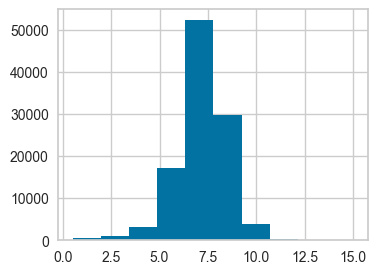

In [1173]:
train['DBWT'].hist(figsize=(4,3));
plt.show();

In [1174]:
train['DBWT'].mean().round(2)

7.19

Average Weight: 7.19 lbs

Male babies are 0.3 lbs larger than female babies. I'll test out building one universal model, as well as two individual models for male / female babies.

In [1175]:
# Underweight babies
len(train[train['DBWT'] < 5.5])

8641

In [1176]:
# Normal babies
len(train[(train['DBWT'] > 5.5) & (train['DBWT'] < 8.8)])

90794

In [1177]:
# Overweight babies
len(train[train['DBWT'] > 8.8])

8647

We'll choose to building a regression model rather than a classification model, due to the lack of underweight and overweight babies.  

In [1178]:
def determine_class(weight):
    if weight <= 5.5:
        x = 'Underweight'
    elif weight > 5.5 and weight <= 8.8:
        x = 'Normal'
    else:
        x = 'Overweight'
    return x

train['Class'] = train['DBWT'].apply(lambda x: determine_class(x))

In [1179]:
num_averages = pd.DataFrame()
num_averages['Underweight Newborn'] = train[train['Class'] == 'Underweight'][['WTGAIN','PWgt_R']].median().round(1)
num_averages['Normal Newborn'] = train[train['Class'] == 'Normal'][['WTGAIN','PWgt_R']].median().round(1)
num_averages['Overweight Newborn'] = train[train['Class'] == 'Overweight'][['WTGAIN','PWgt_R']].median().round(1)
num_averages = num_averages.reset_index().rename(columns={'index':'Features'})
num_averages['Features'] = ['Weight Gain', 'Pre-Pregnancy Weight']

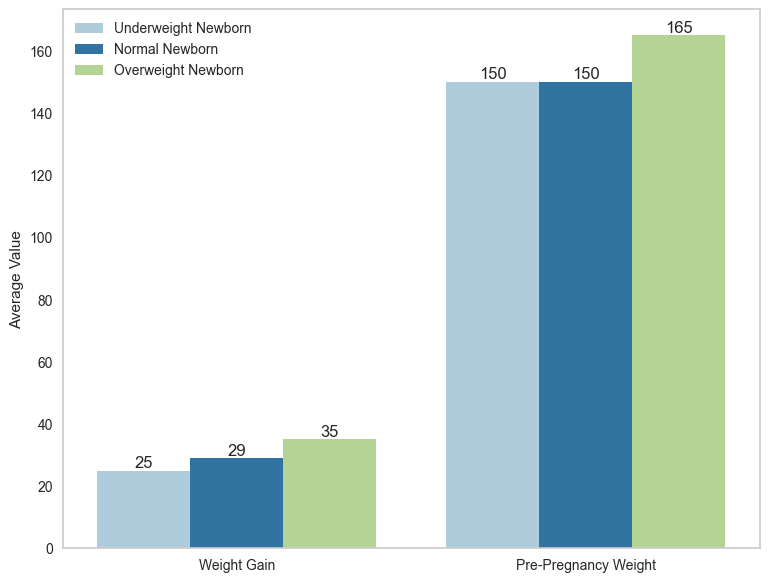

In [1180]:
ax = sns.barplot(
    data=num_averages.melt(id_vars='Features',
                           value_name='Newborn',
                           var_name='course'),
    x='Features', 
    y='Newborn',
    hue='course',
    palette='Paired');

ax.grid(False)
ax.legend(title='')
ax.set(ylabel="Average Value", xlabel='')
ax.bar_label(ax.containers[0]);
ax.bar_label(ax.containers[1]);
ax.bar_label(ax.containers[2]);
plt.show();

Mothers with overweight babies had a larger weight gain.

Mothers with underweight and overweight babies had a higher pre-pregnancy weight.

In [1181]:
num_averages = pd.DataFrame()
underweight_risks = ((train['DBWT'] < 5.5) & (train['NO_RISKS'] != 9))
normal_risks = ((train['DBWT'] > 5.5) & (train['DBWT'] < 8.8) & (train['NO_RISKS'] != 9))
overweight_risks = ((train['DBWT'] > 8.8) & (train['NO_RISKS'] != 9))

num_averages.loc['Underweight Newborn','NO_RISKS'] = (1 - train[underweight_risks]['NO_RISKS'].sum() / train[underweight_risks]['NO_RISKS'].count()) * 100
num_averages.loc['Normal Newborn','NO_RISKS'] = (1 - train[normal_risks]['NO_RISKS'].sum() / train[normal_risks]['NO_RISKS'].count()) * 100
num_averages.loc['Overweight Newborn','NO_RISKS'] = (1 - train[overweight_risks]['NO_RISKS'].sum() / train[overweight_risks]['NO_RISKS'].count()) * 100
num_averages = num_averages.reset_index().rename(columns={'index':'Features'})

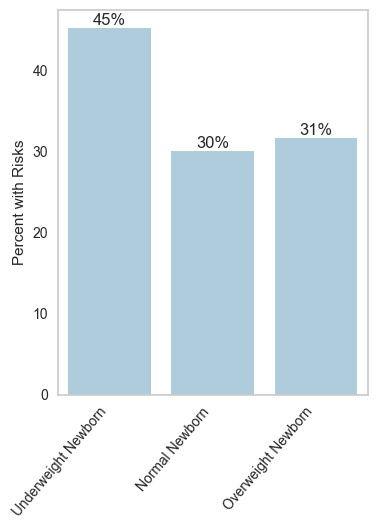

In [1182]:
plt.figure(figsize=(4,5));
ax = sns.barplot(
    data=num_averages.melt(id_vars='Features',
                           value_name='Newborn',
                           var_name='course'),
    x='Features', 
    y='Newborn',
    hue='course',
    palette='Paired');

legend = ax.get_legend()
ax.grid(False)
ax.set(ylabel="Percent with Risks", xlabel='')
legend.remove()
plt.xticks(rotation=50, ha='right')

# add annotations
for c in ax.containers:
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{int(h)}%' if (h := v.get_height()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()

Mothers who had underweight babies seem to have the most amount of risks during the pregnancy (54.8% of mothers with no risks).

## Feature Engineering

Add pregnancy duration and care duration as features

In [1183]:
def estimate_pregnancy_duration(last_period_month, dob_month, precare): 

    year = 2023
    average_days_per_month = 30.437

    if last_period_month == 99 or dob_month == 99:
        return 99, 99
    if last_period_month > dob_month:
        preg_duration = date(year+1, dob_month, 1) -  date(year, last_period_month, 1)
        preg_duration = preg_duration.days
    elif last_period_month < dob_month:
        preg_duration = (dob_month - last_period_month) * average_days_per_month 
    else: # same month
        if precare > 1:
            preg_duration = 365
        else:
            preg_duration = 0
            
    care_duration = round(preg_duration - (precare * average_days_per_month))
    
    if care_duration < 0:
        care_duration = 0
    if preg_duration < 0:
        preg_duration = 0
        
    return int(care_duration), int(preg_duration)

train['care_duration'] = train.apply(lambda x: estimate_pregnancy_duration(x['DLMP_MM'], x['DOB_MM'], x['PRECARE'])[0], axis=1)
train['preg_duration'] = train.apply(lambda x: estimate_pregnancy_duration(x['DLMP_MM'], x['DOB_MM'], x['PRECARE'])[1], axis=1)

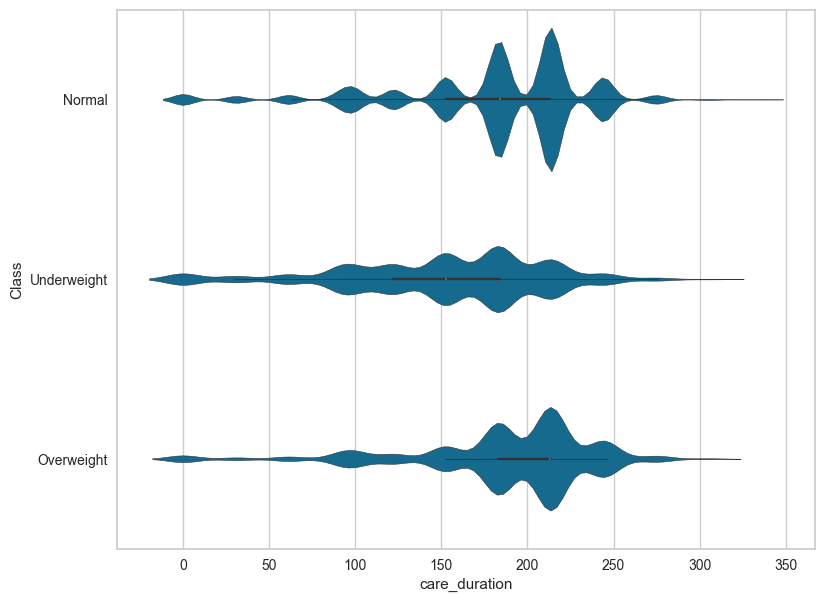

In [1184]:
sns.violinplot(data=train,
               x="care_duration",
               y="Class");

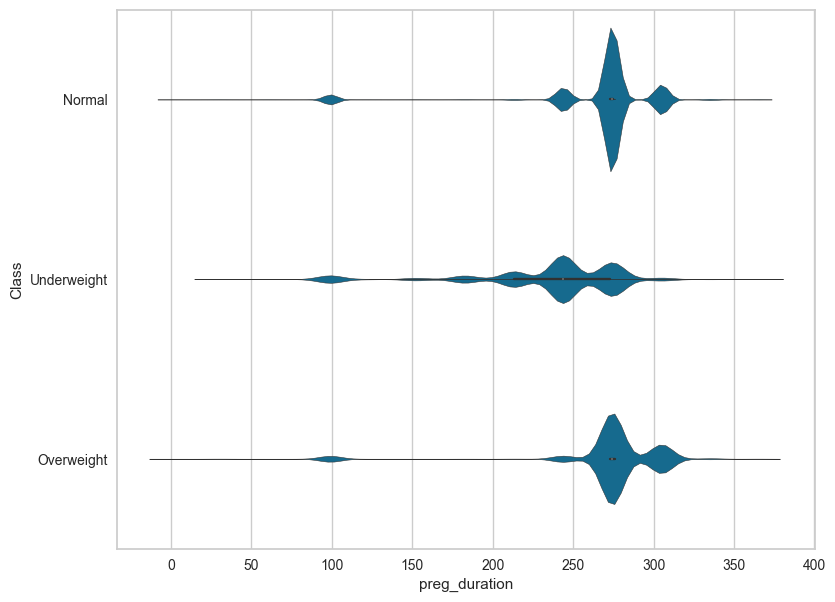

In [1185]:
sns.violinplot(data=train, x="preg_duration", y="Class");

## Preprocessing

Drop features for model building. I experimented using some of these features in the model, but they did not help the model predictions.

In [1186]:
train = train.drop([
 'PAY',
 'RESTATUS',
 'NO_MMORB',
 'PRIORDEAD',
 'RF_CESARN',
 'NO_INFEC',
 'RF_CESAR',
 'DOB_MM',
 'DOB_WK',
 'DOB_TT',
 'PRIORLIVE',
 'PRIORTERM',
 'DLMP_MM',
 'Class',
 'id',
], axis=1)

Group features into categorical and numerical

In [1187]:
categorical_features = [
    'MBSTATE_REC',
    'DMAR',
    'FEDUC',
    'MEDUC',
    'PRECARE',
    'NO_RISKS',
    'ATTEND',
    'BFACIL',
    'RDMETH_REC',
    'SEX',
    'LD_INDL',
    'PAY_REC',
]

numerical_features = [
    'BMI',
    'CIG_0',
    'MAGER',
    'M_Ht_In',
    'PWgt_R',
    'FAGECOMB', 
    'WTGAIN',
    'PREVIS'
]

In [1188]:
# y: target variable
y_train = train['DBWT']
# x values: features
train = train.drop(columns=['DBWT'])

In [1189]:
def outlier_removal(x_df, y_df, std_dev, numerical_features):
    """
    Remove outliers with a zscore less than or greater than provided std_dev
    """
    
    indices = []
    original_length = len(x_df)
    zscore_numeric = x_df[numerical_features].apply(zscore)
        
    for column in zscore_numeric:
        zscore_numeric = zscore_numeric[(zscore_numeric[column] < std_dev)]
        zscore_numeric = zscore_numeric[(zscore_numeric[column] > -std_dev)]
        
    indices = zscore_numeric.index
    
    x_df = x_df.loc[indices]
    y_df = y_df.loc[indices]
    
    print(f"Dropped {original_length - len(x_df)} rows with outliers")
    
    return x_df, y_df

# Remove out zscore > or < 3 std devs
train, y_train = outlier_removal(train, y_train, 3, numerical_features)

Dropped 6943 rows with outliers


In [1190]:
def remove_rows_with_nas(x_df, y_df):
    """
    Remove out rows with values marked as null (can be 99, 3, etc.)
    """
    
    na_dict = {
        'WTGAIN': 99,
        'PREVIS': 99,
        'PWgt_R': 999,
        'M_Ht_In': 99,
        'FAGECOMB': 99,
        'MAGER': 99,
        'BMI': 99.9,
        'CIG_0': 99,
        'MBSTATE_REC': 3,
        'DMAR': 3, 
        'FEDUC': 9,
        'MEDUC': 9,
        'ATTEND': 9,
        'BFACIL': 9,
        'RDMETH_REC': 9,
        'PAY_REC': 9,
        'PRECARE': 99,
        'NO_RISKS': 9,
    }
        
    original_length = len(x_df)
    
    for column in x_df.columns:
        if column in na_dict.keys():
            value = na_dict[column]
            if value:
                x_df = x_df[x_df[column] != value]
                
    y_df = y_df.loc[x_df.index]
    
    print(f"Dropped {original_length - len(x_df)} rows with NAs")
    
    return x_df, y_df


# fill 'DMAR' with 3 (is null)
train['DMAR'] = train['DMAR'].fillna(3)
# remove out nans
train, y_train = remove_rows_with_nas(train, y_train)

Dropped 25616 rows with NAs


In [1191]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75523 entries, 2 to 108080
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ATTEND         75523 non-null  int64  
 1   BFACIL         75523 non-null  int64  
 2   BMI            75523 non-null  float64
 3   CIG_0          75523 non-null  int64  
 4   DMAR           75523 non-null  object 
 5   FAGECOMB       75523 non-null  int64  
 6   FEDUC          75523 non-null  int64  
 7   ILLB_R         75523 non-null  int64  
 8   ILOP_R         75523 non-null  int64  
 9   ILP_R          75523 non-null  int64  
 10  LD_INDL        75523 non-null  object 
 11  MAGER          75523 non-null  int64  
 12  MBSTATE_REC    75523 non-null  int64  
 13  MEDUC          75523 non-null  int64  
 14  M_Ht_In        75523 non-null  int64  
 15  NO_RISKS       75523 non-null  int64  
 16  PAY_REC        75523 non-null  int64  
 17  PRECARE        75523 non-null  int64  
 18  PREVIS    

In [1192]:
# train test split (70% into training, 30% into testing)
x_train_original, x_test_original, y_train, y_test = train_test_split(train, y_train, test_size=0.3, random_state=20)

## Model Selection

In [1193]:
def one_hot_encode_cat_features(df, cat_features):
    """
    One Hot Encoding: Convert categorical features into 0/1s
    """

    one_hot_df = pd.DataFrame()
    
    for column in cat_features:
        one_hot_feature = pd.get_dummies(df[column], prefix=column)
        one_hot_df = pd.concat([one_hot_feature, one_hot_df],axis=1)   
            
    one_hot_df = one_hot_df.fillna(0)
    
    return one_hot_df

In [1194]:
def one_hot_encode_num_features(df, numerical_features, na=True):
    """
    One Hot Encoding: converting numerical features into buckets, and then converting to 0/1s
    """

    one_hot_df = pd.DataFrame()
    
    if na==True:  
        for column in numerical_features:
            if 'BMI':
                one_hot_df['BMI_99'] = df[df['BMI'] == 99.9]['BMI']
            elif 'PWgt_R':
                one_hot_df['PWgt_R_999'] = df[df['PWgt_R'] == 999]['PWgt_R']
            else:
                one_hot_df[column+"_99"] = df[df[column] == 99][column]

    if 'CIG_0' in numerical_features:
        one_hot_df['CIG_0'] = df[df['CIG_0'] == 0]['CIG_0']
        one_hot_df['CIG_1'] = df[(df['CIG_0'] > 0) & (df['CIG_0'] != 99)]['CIG_0']

    if 'BMI' in numerical_features:
        feature_categorical = pd.cut(df[df['BMI'] != 99.9]['BMI'], bins=[13,20,30,40,50,60,70])
        one_hot_feature = pd.get_dummies(feature_categorical, prefix='BMI')
        one_hot_df = pd.concat([one_hot_feature, one_hot_df],axis=1)
    
    if 'MAGER' in numerical_features: 
        feature_categorical = pd.cut(df[df['MAGER'] != 99]['MAGER'], bins=[13,20,25,30,40,50,60,70])
        one_hot_feature = pd.get_dummies(feature_categorical, prefix='MAGER')
        one_hot_df = pd.concat([one_hot_feature, one_hot_df],axis=1)
        
    if 'FAGECOMB' in numerical_features: 
        feature_categorical = pd.cut(df[df['FAGECOMB'] != 99]['FAGECOMB'], bins=[13,20,25,30,40,50,60,70])
        one_hot_feature = pd.get_dummies(feature_categorical, prefix='FAGECOMB')
        one_hot_df = pd.concat([one_hot_feature, one_hot_df],axis=1)

    if 'M_Ht_In' in numerical_features:
        feature_categorical = pd.cut(df[df['M_Ht_In'] != 99]['M_Ht_In'], bins=[10,20,25,30,40,50,60,70])
        one_hot_feature = pd.get_dummies(feature_categorical, prefix='M_Ht_In')
        one_hot_df = pd.concat([one_hot_feature, one_hot_df],axis=1)

    if 'PWgt_R' in numerical_features:
        feature_categorical = pd.cut(df[df['PWgt_R'] != 999]['PWgt_R'], bins=[50,100,150,200,250,300,350,400])
        one_hot_feature = pd.get_dummies(feature_categorical, prefix='PWgt_R')
        one_hot_df = pd.concat([one_hot_feature, one_hot_df],axis=1)

    if 'WTGAIN' in numerical_features:
        feature_categorical = pd.cut(df[df['WTGAIN'] != 99]['WTGAIN'], bins=[50,100,150,200,250,300,350,400])
        one_hot_feature = pd.get_dummies(feature_categorical, prefix='WTGAIN')
        one_hot_df = pd.concat([one_hot_feature, one_hot_df],axis=1)

    if 'PREVIS' in numerical_features:
        feature_categorical = pd.cut(df[df['PREVIS'] != 99]['PREVIS'], bins=[0,5,10,15,20,40,60])
        one_hot_feature = pd.get_dummies(feature_categorical, prefix='PREVIS')
        one_hot_df = pd.concat([one_hot_feature, one_hot_df],axis=1)
    
    one_hot_df = one_hot_df.fillna(0)
    
    return one_hot_df

In [1195]:
def k_fold_cv(x_train, y_train, model):
    """
    K-Fold Cross Validation
    """
    
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, 
                             x_train, 
                             y_train, 
                             scoring='neg_root_mean_squared_error',
                             cv=cv,
                             n_jobs=-1)
    scores = absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()))

### 1. Lasso Regression

In [1196]:
def fit_lasso_model(x_train, y_train, x_test):

    lasso = Lasso(random_state=0, max_iter=10000, alpha = 10)
    lasso.fit(x_train, y_train)
    train_score_ls =lasso.score(x_train,y_train)
    test_score_ls =lasso.score(x_test,y_test)
    y_pred = lasso.predict(x_test)

    print("The train score for ls model is {}".format(train_score_ls))
    print("The test score for ls model is {}".format(test_score_ls))
    
    return y_pred

In [1197]:
# One Hot Encoding
one_hot_cat = one_hot_encode_cat_features(x_train_original, categorical_features)
one_hot_num = one_hot_encode_num_features(x_train_original, numerical_features, na=True)
x_train = pd.concat([one_hot_cat, one_hot_num], axis=1)

one_hot_cat = one_hot_encode_cat_features(x_test_original, categorical_features)
one_hot_num = one_hot_encode_num_features(x_test_original, numerical_features, na=True)
x_test = pd.concat([one_hot_cat, one_hot_num], axis=1)

In [1198]:
y_pred_lasso = fit_lasso_model(x_train, y_train, x_test)

The train score for ls model is 0.0
The test score for ls model is -2.6363158266651254e-05


In [1199]:
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_lasso

1.6328388927777167

In [1200]:
rmse_lasso = math.sqrt(mse_lasso)
rmse_lasso

1.2778258460282124

### 2. XGB Regression

In [1201]:
def fit_xgb_regressor(x_train, y_train, x_test, objective='reg:squarederror'):
    
    xgb_model = XGBRegressor(enable_categorical=True, objective=objective)
    xgb_model.fit(x_train, y_train)
    
    y_pred = xgb_model.predict(x_test)

    return y_pred, xgb_model

In [1202]:
x_train_xgb = x_train_original.copy()
x_test_xgb = x_test_original.copy()

x_train_xgb[categorical_features] = x_train_original[categorical_features].astype('category')
x_test_xgb[categorical_features] = x_test_original[categorical_features].astype('category')

In [1203]:
y_pred_xgb, xgb_model = fit_xgb_regressor(x_train_xgb, y_train, x_test_xgb)

In [1204]:
y_pred_xgb

array([7.440751 , 7.9744744, 8.446981 , ..., 7.2108316, 5.2858653,
       5.5298266], dtype=float32)

In [1205]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mse_xgb

1.0786980880153354

In [1206]:
rmse_xgb = math.sqrt(mse_xgb)
rmse_xgb

1.038603912959765

In [1207]:
k_fold_cv(x_train_xgb, y_train, xgb_model)

Mean RMSE: 1.032 (0.014)


### 3. Ridge Regression

In [1208]:
def fit_ridge_model(x_train, y_train, x_test):
    
    ridge = Ridge()
    ridge.fit(x_train,y_train)
    y_pred = ridge.predict(x_test)
    
    return y_pred

In [1209]:
# One Hot Encoding
one_hot_cat = one_hot_encode_cat_features(x_train_original, categorical_features)
one_hot_num = one_hot_encode_num_features(x_train_original, numerical_features, na=True)
x_train_ridge = pd.concat([one_hot_cat, one_hot_num], axis=1)

one_hot_cat = one_hot_encode_cat_features(x_test_original, categorical_features)
one_hot_num = one_hot_encode_num_features(x_test_original, numerical_features, na=True)
x_test_ridge = pd.concat([one_hot_cat, one_hot_num], axis=1)

In [1210]:
y_pred_ridge = fit_ridge_model(x_train_ridge, y_train, x_test_ridge)

In [1211]:
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_ridge

1.4471194329320107

In [1212]:
rmse_ridge = math.sqrt(mse_ridge)
rmse_ridge

1.2029627728787

### 4. Evaluating Performance 

In [1213]:
metrics = pd.DataFrame()
metrics.loc['MSE','Lasso'] = mse_lasso
metrics.loc['MSE','Ridge'] = mse_ridge
metrics.loc['MSE','XGBoost'] = mse_xgb

metrics.loc['RMSE','Lasso'] = rmse_lasso
metrics.loc['RMSE','Ridge'] = rmse_ridge
metrics.loc['RMSE','XGBoost'] = rmse_xgb

metrics = metrics.T.round(2)
metrics

,MSE,RMSE
Lasso,1.63,1.28
Ridge,1.45,1.20
XGBoost,1.08,1.04


XGBoost Regression has the lowest MSE and RMSE. We'll use XGBoost Regression, and work on improving it.

## Feature Importance

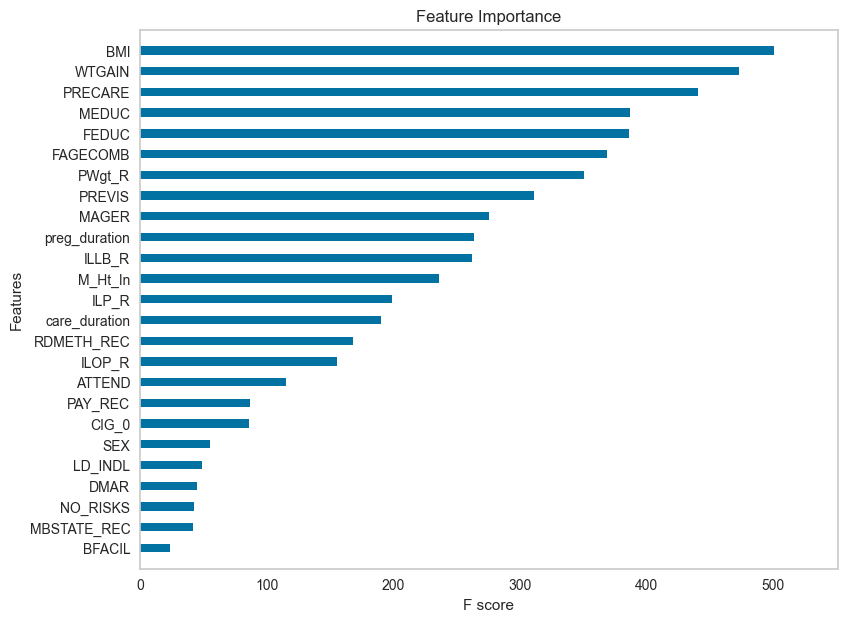

In [1214]:
plt.rcParams["figure.figsize"] = (9, 7)
plot_importance(xgb_model, 
                height=0.4, 
                title='Feature Importance',
                show_values=False,
                grid=False,
               )
plt.show();

#### Features with the highest importance:
- **BMI:** Body Mass Index (13.0 - 69.9 BMI)
- **WTGAIN:** Weight gain in pounds
- **PRECARE:** Month Prenatal Care Began (00 No prenatal care 01-10 Month prenatal care began)
- **PREVIS:** Number of Prenatal Visits (00-98 Number of prenatal visits)
- **FEDUC:** Father’s Education - 8th grade or less, high school graduate, college degree, etc.
- **MEDUC:** Mother’s Education
- **FAGECOMB:** Father’s Combined Age (09-98)
- **PWgt_R:** Pre-pregnancy Weight in Pounds (075-375 lbs)

#### Features with the lowest importance:
- **SEX:** Male or Female
- **LD_INDL**: Induction of Labor
- **DMAR:** Marital Status
- **NO_RISKS:** If any risks during pregnancy
- **MBSTATE_REC:** Mother’s Nativity - born in the US, born outside the US, etc.
- **BFACIL:** Birth Place - Hospital, Home, etc.



- Can also use Shapley values to see if this positively or negatively impacts the prediction weight.

## Model Improvements

### 1. Using Selected Features
We'll drop the features with the lowest importance, since they don't influence the predictions as much.

In [1215]:
x_test_xgb_less = x_test_xgb.drop(columns=[
    'SEX',
    'LD_INDL',
    'DMAR',
    'NO_RISKS',
    'MBSTATE_REC',
    'BFACIL'
])
x_train_xgb_less = x_train_xgb.drop(columns=[
    'SEX',
    'LD_INDL',
    'DMAR',
    'NO_RISKS',
    'MBSTATE_REC',
    'BFACIL'
])

In [1216]:
y_pred_xgb_less, xgb_model_less = fit_xgb_regressor(x_train_xgb_less, y_train, x_test_xgb_less)

In [1217]:
mse_xgb_less_features = mean_squared_error(y_test, y_pred_xgb_less)
mse_xgb_less_features

1.1065510548646373

In [1218]:
rmse_xgb_less_features = math.sqrt(mse_xgb_less_features)
rmse_xgb_less_features

1.0519273049334907

In [1219]:
k_fold_cv(x_train_xgb_less, y_train, xgb_model_less)

Mean RMSE: 1.046 (0.012)


### 2. Upsampling Underweight and Overweight Babies
Increasing the number of records for underweight and overweight babies.

In [1220]:
y_train_underweight = y_train[(y_train < 5.5)]
y_train_overweight = y_train[(y_train >= 8.8)]
y_train_filtered =  y_train[(y_train >= 5.5) &(y_train < 8.8)]

x_train_overweight = x_train_xgb.loc[y_train_overweight.index]
x_train_underweight = x_train_xgb.loc[y_train_underweight.index]
x_train_filtered = x_train_xgb.loc[y_train_filtered.index]

In [1221]:
train_underweight = pd.concat([x_train_underweight, y_train_underweight], axis=1)
train_overweight = pd.concat([x_train_overweight, y_train_overweight], axis=1)

train_underweight = resample(train_underweight,
                         replace=True,
                         n_samples=int(len(y_train_filtered)),
                         random_state=42)

train_overweight = resample(train_overweight,
                            replace=True,
                            n_samples=int(len(y_train_filtered) / 2),
                            random_state=42)

In [1222]:
y_train_underweight = train_underweight['DBWT']
x_train_underweight = train_underweight.loc[:, train_underweight.columns != 'DBWT']

y_train_overweight = train_overweight['DBWT']
x_train_overweight = train_overweight.loc[:, train_overweight.columns != 'DBWT']

In [1223]:
y_train_upsampled = pd.concat([
    y_train_underweight,
    y_train_filtered,
    y_train_overweight
]).reset_index(drop=True)

x_train_upsampled = pd.concat([
    x_train_underweight, 
    x_train_filtered, 
    x_train_overweight
]).reset_index(drop=True)

In [1224]:
len(x_train_upsampled)

111622

In [1225]:
y_pred_xgb_upsampled, xgb_model_upsampled = fit_xgb_regressor(x_train_upsampled, 
                                                              y_train_upsampled, 
                                                              x_test_xgb, 
                                                              objective='reg:gamma')

In [1226]:
mse_xgb_upsampled = mean_squared_error(y_test, y_pred_xgb_upsampled)
mse_xgb_upsampled

1.413244495343842

In [1227]:
rmse_xgb_upsampled = math.sqrt(mse_xgb_upsampled)
rmse_xgb_upsampled

1.1887996026849277

### 3. Splitting Model Based on Sex

In [1228]:
x_male_train_xgb = x_train_xgb[x_train_xgb['SEX'] == 'M']
x_male_test_xgb = x_test_xgb[x_test_xgb['SEX'] == 'M']
x_female_train_xgb = x_train_xgb[x_train_xgb['SEX'] == 'F']
x_female_test_xgb = x_test_xgb[x_test_xgb['SEX'] == 'F']
y_male_train = y_train.loc[x_male_train_xgb.index]
y_female_train = y_train.loc[x_female_train_xgb.index]
y_male_test = y_test.loc[x_male_test_xgb.index]
y_female_test= y_test.loc[x_female_test_xgb.index]

In [1229]:
y_pred_xgb_male, xgb_male_model = fit_xgb_regressor(x_male_train_xgb, y_male_train, x_male_test_xgb)

In [1230]:
y_pred_xgb_female, xgb_female_model = fit_xgb_regressor(x_female_train_xgb, y_female_train, x_female_test_xgb)

In [1231]:
mse_xgb_male = mean_squared_error(y_male_test, y_pred_xgb_male)
mse_xgb_male

1.1600407076599455

In [1232]:
mse_xgb_female = mean_squared_error(y_female_test, y_pred_xgb_female)
mse_xgb_female

1.0539599278393115

In [1233]:
rmse_xgb_male = math.sqrt(mse_xgb_male)
rmse_xgb_male

1.0770518593178071

In [1234]:
rmse_xgb_female = math.sqrt(mse_xgb_female)
rmse_xgb_female

1.0266255051572173

### 4. Using One-Hot Encoded Features

In [1235]:
one_hot_cat = one_hot_encode_cat_features(x_train_original, categorical_features)
one_hot_num = one_hot_encode_num_features(x_train_original, numerical_features, na=True)
x_train = pd.concat([one_hot_cat, one_hot_num], axis=1)
x_train = x_train.astype('float')

one_hot_cat = one_hot_encode_cat_features(x_test_original, categorical_features)
one_hot_num = one_hot_encode_num_features(x_test_original, numerical_features, na=True)
x_test = pd.concat([one_hot_cat, one_hot_num], axis=1)
x_test = x_test.astype('float')

In [1236]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_train.columns.values]
x_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_test.columns.values]

In [1237]:
y_pred_xgb, xgb_model_one_hot = fit_xgb_regressor(x_train, y_train, x_test)

In [1238]:
mse_xgb_one_hot_encoded = mean_squared_error(y_test, y_pred_xgb)
mse_xgb_one_hot_encoded

1.470003781282011

In [1239]:
rmse_xgb_one_hot_encoded = math.sqrt(mse_xgb_one_hot_encoded)
rmse_xgb_one_hot_encoded

1.2124371246716306

## Model Evaluation

In [1240]:
metrics = pd.DataFrame()
metrics.loc['MSE','All Features'] = mse_xgb
metrics.loc['MSE','Selected Features'] = mse_xgb_less_features
metrics.loc['MSE','Male Model'] = rmse_xgb_male
metrics.loc['MSE','Female Model'] = rmse_xgb_female
metrics.loc['MSE','Upsampled'] = mse_xgb_upsampled

metrics.loc['RMSE','All Features'] = rmse_xgb
metrics.loc['RMSE','Selected Features'] = rmse_xgb_less_features
metrics.loc['RMSE','Male Model'] = rmse_xgb_male
metrics.loc['RMSE','Female Model'] = rmse_xgb_female
metrics.loc['RMSE','Upsampled'] = rmse_xgb_upsampled

metrics = metrics.T

In [1241]:
metrics.sort_values('RMSE').round(2)

,MSE,RMSE
Female Model,1.03,1.03
All Features,1.08,1.04
Selected Features,1.11,1.05
Male Model,1.08,1.08
Upsampled,1.41,1.19


Model with selected features and all features does the best. Splitting the model into male/female also yields good results. Upsampling doesn't yield good results.

### Creating A Prediction Interval

In [1242]:
pd.set_option('future.no_silent_downcasting', True)
model = make_pipeline(
    OneHotEncoder(cols = categorical_features),
    XGBRegressor(enable_categorical=True, random_state = 30)
).fit(x_train_xgb, y_train)

cqr = MapieRegressor(model, cv = 'prefit').fit(x_test_xgb, y_test)
y_pred_mapie, pred_interval = cqr.predict(x_test_xgb, alpha = .1)

In [1243]:
mse_mapie = mean_squared_error(y_test, y_pred_mapie)
mse_mapie

1.068592207673657

In [1244]:
rmse_mapie = math.sqrt(mse_xgb)
rmse_mapie

1.038603912959765

In [1245]:
interval_1 = []
interval_2 = []
for n in range(0, len(y_test)):
    interval_1.append(pred_interval[n][0][0])
    interval_2.append(pred_interval[n][1][0])

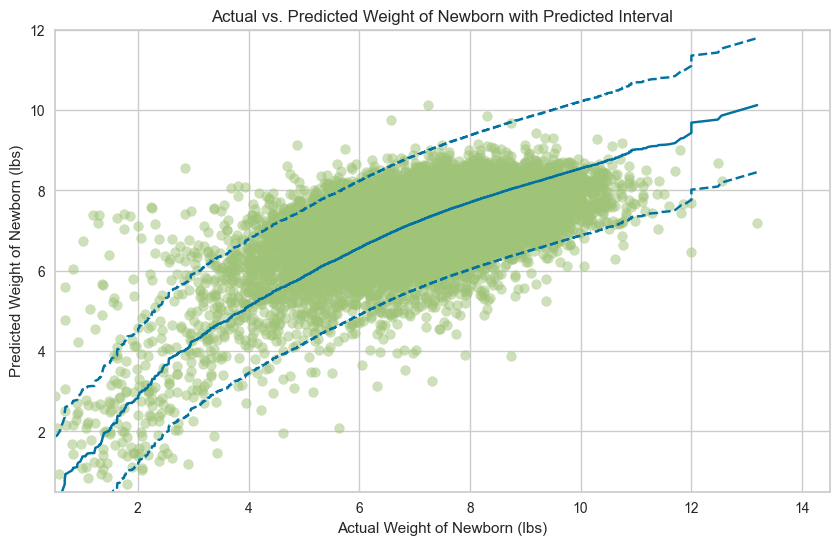

In [1246]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_mapie, alpha=0.5, color='g')
plt.plot(sorted(y_test), sorted(y_pred_mapie))
plt.plot(sorted(y_test), sorted(interval_1), color='b', linestyle='--')
plt.plot(sorted(y_test), sorted(interval_2), color='b', linestyle='--')
plt.xlabel("Actual Weight of Newborn (lbs)")
plt.ylabel("Predicted Weight of Newborn (lbs)")
plt.title("Actual vs. Predicted Weight of Newborn with Predicted Interval")
plt.xlim(0.5,14.5)
plt.ylim(0.5,12)
plt.show()

In [1247]:
metrics.loc['XGBoost - Interval','MSE'] = mse_mapie
metrics.loc['XGBoost - Interval','RMSE'] = rmse_mapie

In [1248]:
y_values = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(y_pred_mapie), pd.DataFrame(interval_1), pd.DataFrame(interval_2)], axis=1)
y_values.columns = ['Birth Weight', 'Prediction', 'Lower Interval', 'Higher Interval']

In [1249]:
y_values.sort_values('Birth Weight')

,Birth Weight,Prediction,Lower Interval,Higher Interval
20066,0.511472,2.893337,1.225004,4.561670
22475,0.540132,2.091623,0.423290,3.759956
5367,0.584224,0.941194,-0.727139,2.609527
7977,0.679023,2.501824,0.833491,4.170157
5437,0.681228,4.772442,3.104109,6.440775
...,...,...,...,...
9901,11.999747,6.473529,4.805196,8.141862
5884,11.999747,7.679532,6.011199,9.347865
14754,12.478149,8.682027,7.013694,10.350360
21088,12.544288,8.242942,6.574609,9.911275


An interval adds a measure of reliability to the predictions. 

In [1250]:
metrics.sort_values('RMSE').round(2)

,MSE,RMSE
Female Model,1.03,1.03
All Features,1.08,1.04
XGBoost - Interval,1.07,1.04
Selected Features,1.11,1.05
Male Model,1.08,1.08
Upsampled,1.41,1.19


The predictions with the interval are performing similarly to our base model using all the features.

In [1251]:
sample_x = shap.utils.sample(x_train, 5000, random_state=100)

## Case Studies
Looking at individual records and their Shapley Values
- Blue: drives prediction to be negative
- Pink: drives prediction to be positive

### 1. Underweight Baby

In [1253]:
np.argsort(xgb_model_one_hot.predict(sample_x))[:10]

array([3464, 4773, 2978, 2053, 2885,  763, 4844, 3655, 1628,  159])

In [1254]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(xgb_model_one_hot.predict, x_train)
shap_values = explainer(sample_x)

PermutationExplainer explainer: 5001it [02:36, 30.08it/s]                       


In [1266]:
# Actual Weight
y_train.loc[sample_x.iloc[4773].name]

3.1856759

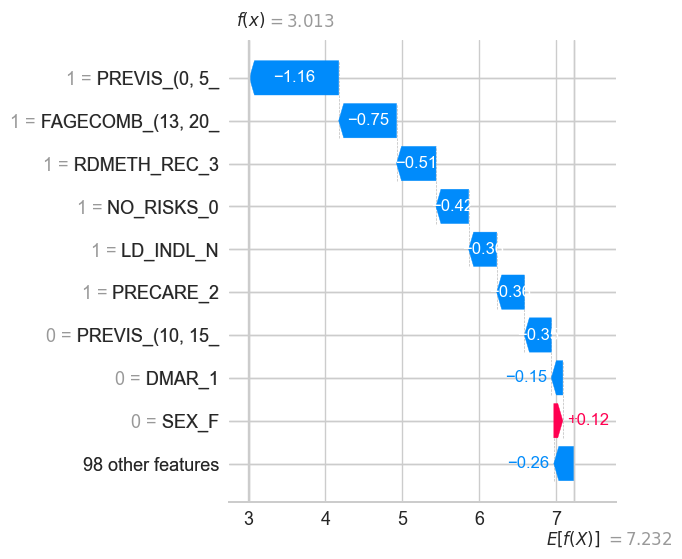

In [1267]:
shap.plots.waterfall(shap_values[4773], show=False, max_display=10)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(5)
plt.show();


Features that drive the prediction to be:
- (Negative) PREVIS: Number of Prenatal Visits is between 0-5
- (Negative) FAGECOMB: Father's Age is between 13-20.
- (Negative) RDMETH_REC: Primary C-section

### 2. Normal Baby

In [1269]:
# Actual Weight
y_train.loc[sample_x.iloc[9].name]

7.4957080000000005

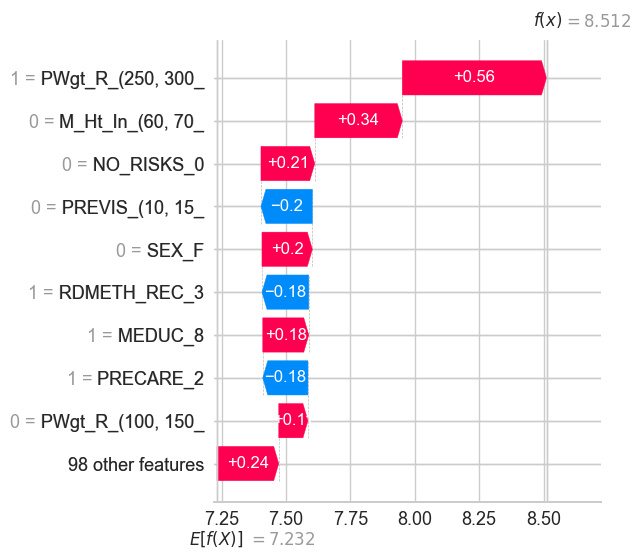

In [1270]:
shap.plots.waterfall(shap_values[9], show=False, max_display=10)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(5)
plt.show()

Features that drive the prediction to be:
- (Positive) PWgt_R: Pre-pregnancy Weight, 250-300 lbs
- (Positive) Mother's Height: 60-70"
- (Positive) No Risks during pregnancy